In [1]:
import os
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [2]:
os.chdir('../')

### Train RF on banana dataset

In [3]:
df = pd.read_csv('./data/banana.csv')
X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

clf = RandomForestClassifier(n_estimators=3, random_state=7)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(f'Test accuracy: {accuracy:.2f}')

Test accuracy: 0.88


### Visualize decision boundaries

##### Boundaries of each tree

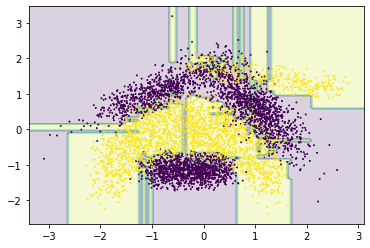

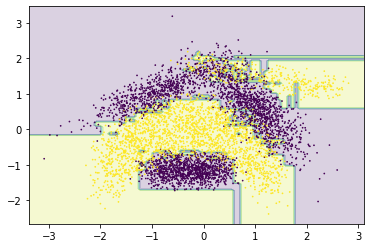

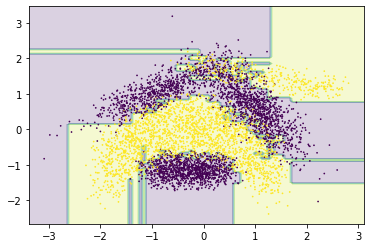

<Figure size 432x288 with 0 Axes>

In [4]:
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=0.5)

# Create a grid of points over the plot
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Apply the decision function of each tree to the grid of points
tree_preds = []
for i,tree in enumerate(clf.estimators_):
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=0.5)
    plt.title('Decision Boundary of Tree {} in RF'.format(i+1))
    plt.savefig('figures/example_tree{}.png'.format(i+1), bbox_inches='tight', dpi=300)
    plt.show()
    plt.clf()

    tree_preds.append(tree.predict_proba(np.c_[xx.ravel(), yy.ravel()]))

##### Boundary of full RF

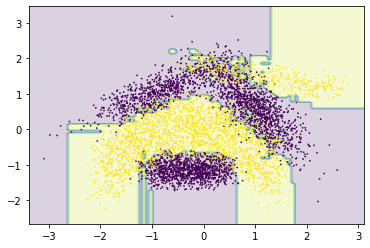

<Figure size 432x288 with 0 Axes>

In [5]:
Z = np.array(tree_preds).mean(axis=0).argmax(axis=1)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.2)
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=0.5)
plt.title('Decision Boundary of RF')
plt.savefig('figures/rf.png', bbox_inches='tight', dpi=300)
plt.show()
plt.clf()

##### Boundary of RF with random weighted averaging

[0.1, 0.3, 0.6]


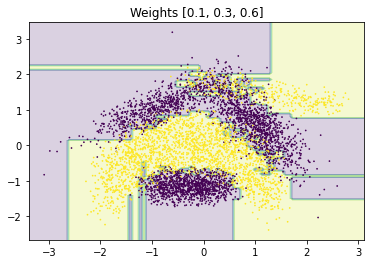

[0.3, 0.6, 0.1]


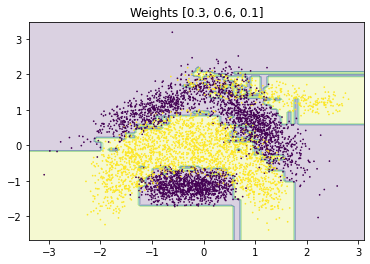

[0.6, 0.1, 0.3]


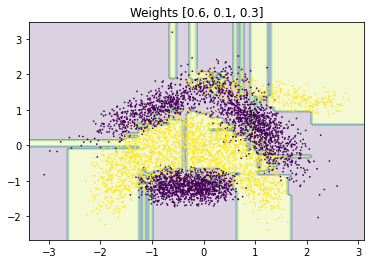

<Figure size 432x288 with 0 Axes>

In [6]:
weights = [[0.1, 0.3, 0.6], [0.3, 0.6, 0.1], [0.6, 0.1, 0.3]]
for w in weights:
    Z = np.average(np.array(tree_preds), axis=0, weights=w).argmax(axis=1)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=0.5)
    plt.title('Decision Boundary of RF with Weights {}'.format(w))
    plt.savefig('figures/rf_weighted_w{}.png'.format(w), bbox_inches='tight', dpi=300)
    plt.show()
    plt.clf()